## Анализ прогнозируемости

Эта тетрадка содержит простые примеры анализа прогнозируемости с использованием библиотеки ETNA.

**Содержание**
* [Загрузка набора данных](#section_1)
* [Загрузка предварительно обученного анализатора](#section_2)
* [Анализ прогнозируемости сегментов](#section_3)

**Формулировка задачи**: Дан набор временных рядов $\{x_i\}_{i=1}^{N}$. Нам нужно определить, можно ли прогнозировать каждый из рядов не ниже определенного порога качества.

Анализ прогнозируемости помогает выполнить некую предварительную проверку на наборе данных. Он может помочь выявить "плохие" сегменты, которые следует обрабатывать отдельно.

### Загрузка набора данных  <a class="anchor" id="section_1"></a>

Чтобы продемонстрировать использование этого инструмента, мы воспользуемся набором данных M4.

In [1]:
# импортируем необходимые библиотеки, классы и функции
import pandas as pd
from tqdm.notebook import tqdm

from etna.datasets import TSDataset
from etna.pipeline import Pipeline
from etna.models import NaiveModel
from etna.metrics import SMAPE

%config InlineBackend.figure_format = 'retina'

In [2]:
# загружаем файл с набором ежедневных данных соревнования M4
!curl 'https://raw.githubusercontent.com/Mcompetitions/M4-methods/master/Dataset/Train/Daily-train.csv' -o m4.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 91.3M  100 91.3M    0     0  6707k      0  0:00:13  0:00:13 --:--:-- 10.0M


In [3]:
# загружаем из файла набор данных соревнования M4
df_raw = pd.read_csv('m4.csv')

In [4]:
# меняем формат загруженного набора данных, превратив его 
# в 4227 временных рядов разной длины
dfs = []
for i in tqdm(range(len(df_raw))):
    segment_name = df_raw.iloc[i, 0]
    segment_values = df_raw.iloc[i, 1:].dropna().astype(float).values
    segment_len = len(segment_values)
    timestamps = pd.date_range(
        start=pd.to_datetime('2022-11-04') - pd.to_timedelta('1d') * 
        (segment_len - 1), end='2022-11-04')
    df_segment = pd.DataFrame({'target': segment_values, 
                               'segment': segment_name,
                               'timestamp': timestamps})
    dfs.append(df_segment)

  0%|          | 0/4227 [00:00<?, ?it/s]

In [5]:
# преобразовываем временные ряды в формат сегментов ETNA
df = pd.concat(dfs)
df = TSDataset.to_dataset(df)
ts = TSDataset(df=df, freq='D')

Давайте визуализируем несколько сегментов из набора данных.

Кол-во сегментов: 4227


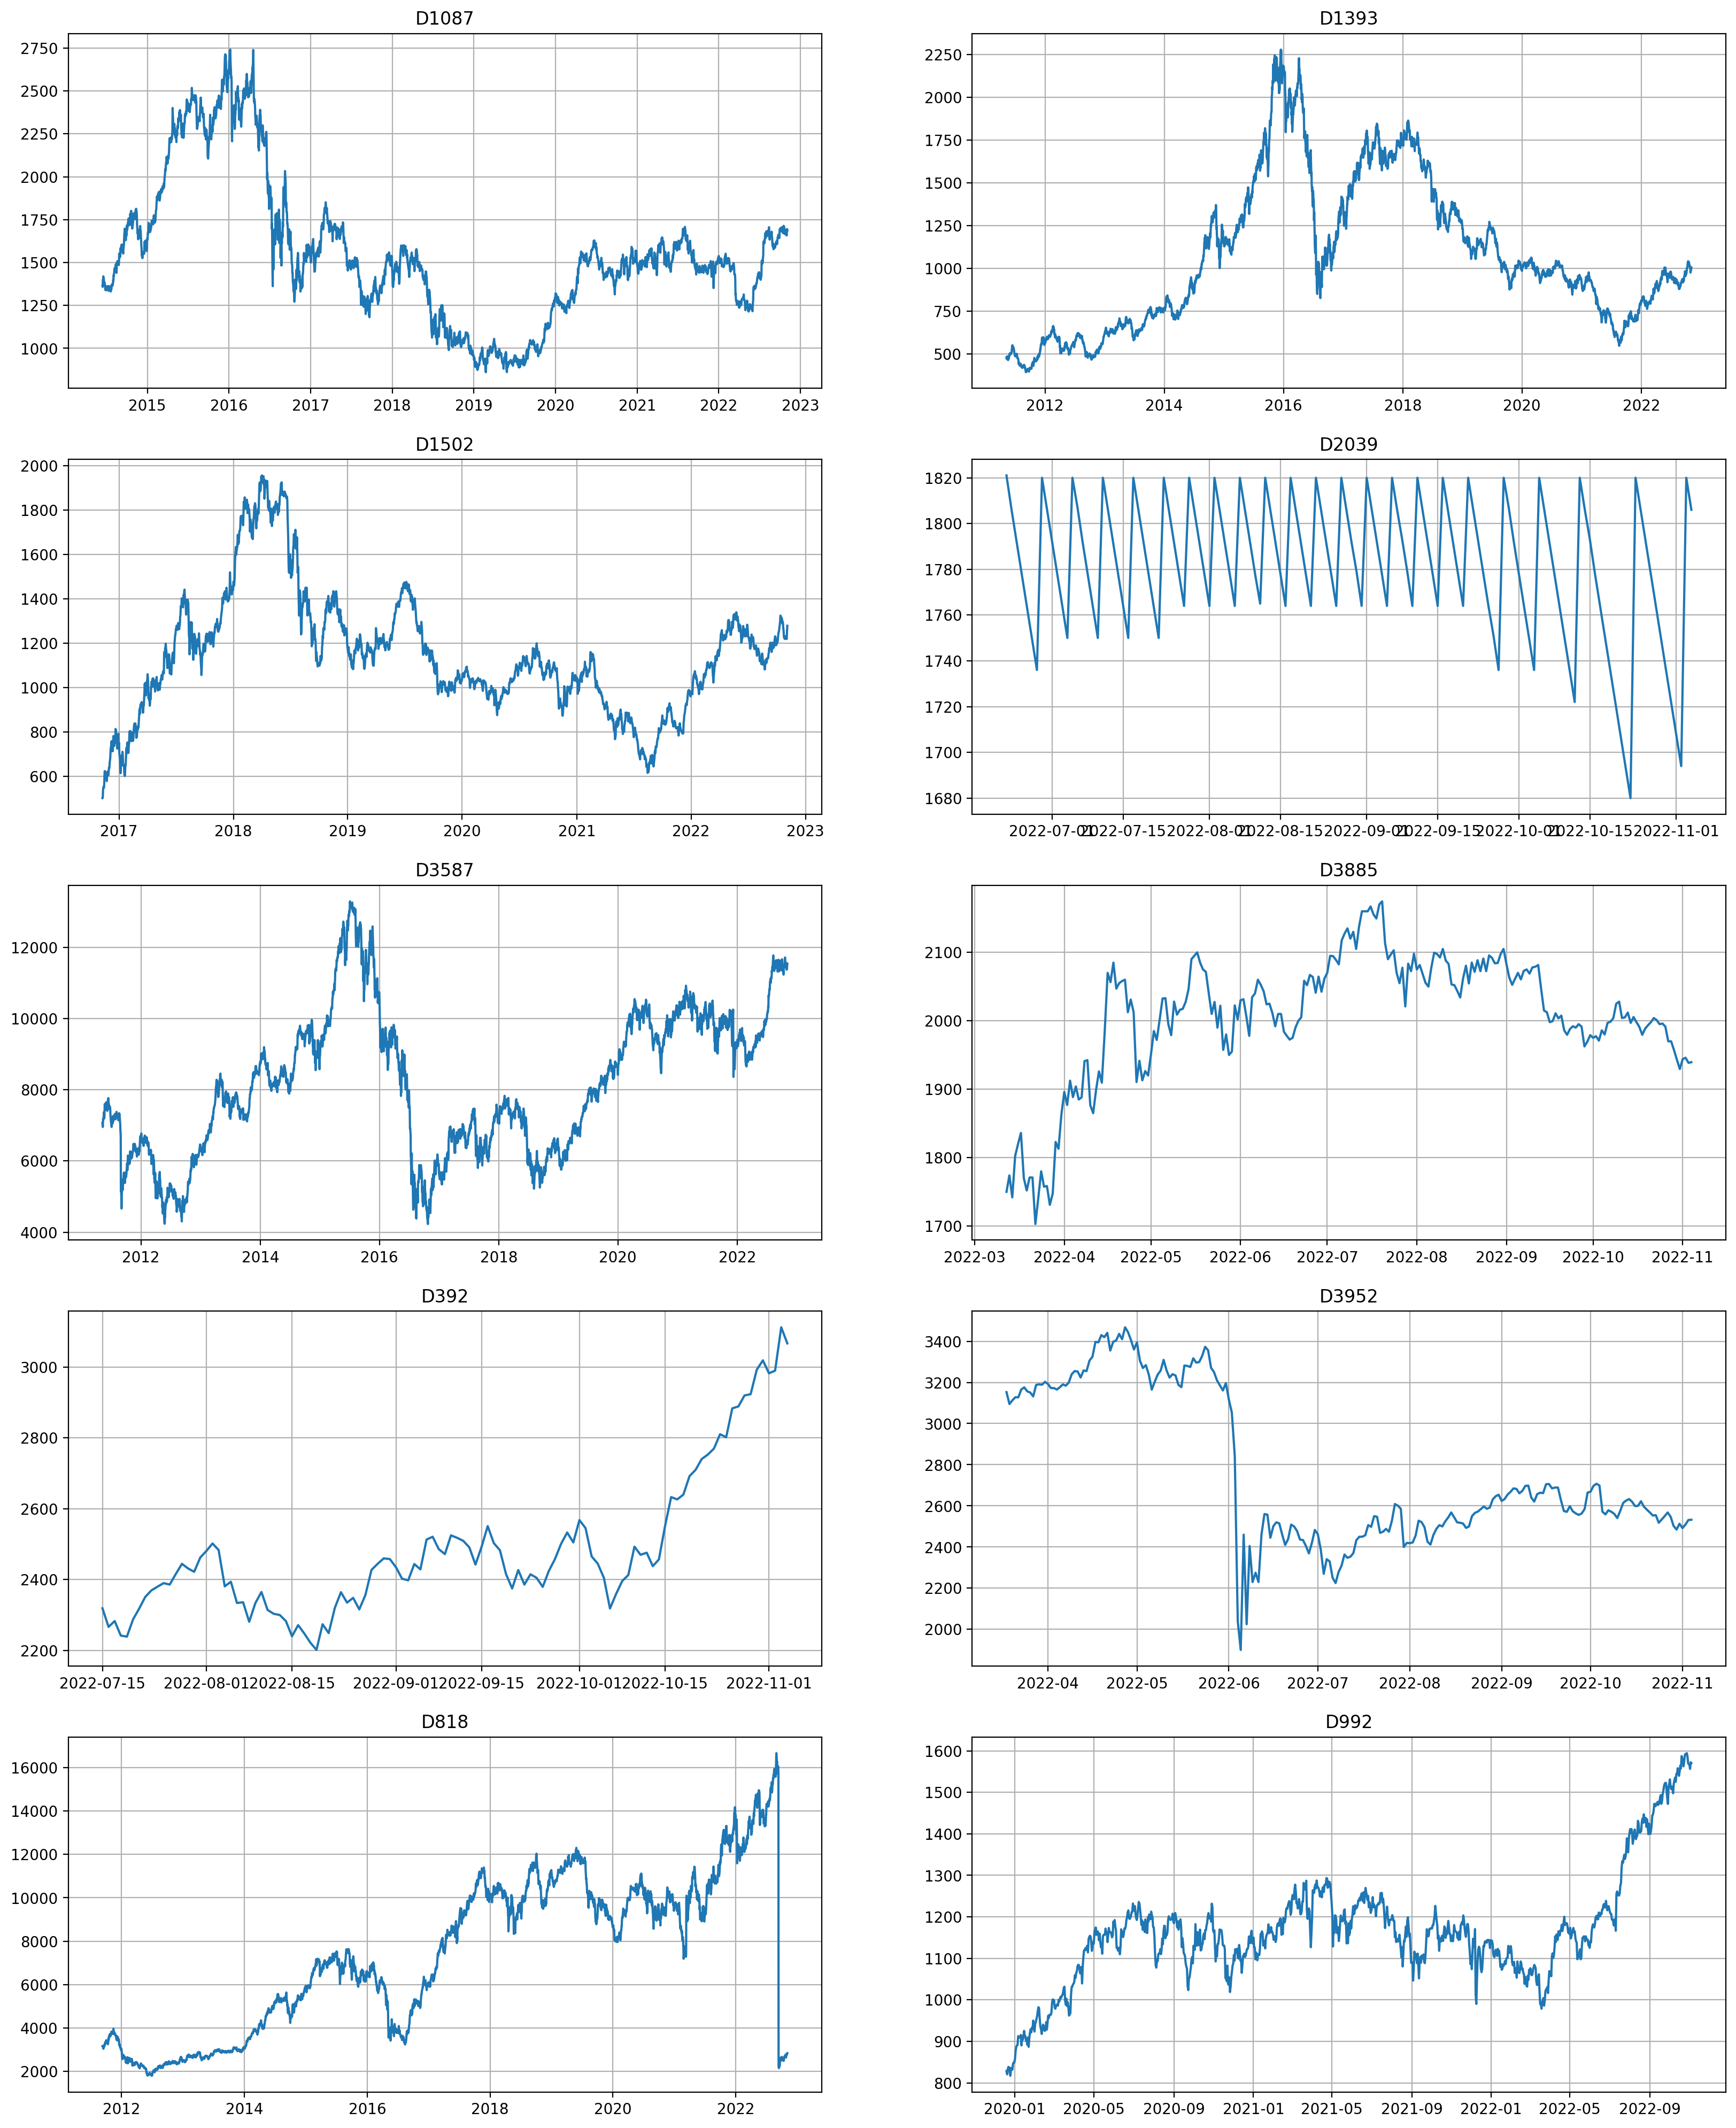

In [6]:
# визуализируем 10 сегментов
print('Кол-во сегментов:', len(ts.segments))
ts.plot(n_segments=10)

Набор данных состоит из более чем четырех тысяч сегментов длиной 1-4 года. Как видно из графиков, поведение сегментов в наборе данных различно, и точно предсказать все из них может быть сложно. Давайте попробуем оценить метрику SMAPE с помощью перекрестной проверки расширяющимся окном, используя некоторую базовую модель.

In [7]:
# создаем конвейер с моделью наивного прогноза 
# и горизонтом прогнозирования 30 дней
pipeline = Pipeline(model=NaiveModel(), 
                    transforms=[], 
                    horizon=30)

In [8]:
# выполняем перекрестную проверку расширяющимся окном
metrics, _, _ = pipeline.backtest(ts, 
                                  metrics=[SMAPE()], 
                                  n_folds=3, 
                                  aggregate_metrics=False)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:333: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   22.0s remaining:    0.0s
/opt/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:333: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   44.0s remaining:    0.0s
/opt/anaconda3/lib/python3.9/site-packages/etna/datasets/tsdataset.py:333: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  future_dates = pd.date_range(
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  1.1min finished


Даже для наивной модели оценка качества на этом наборе данных занимает около 2 минут. Представьте, сколько времени потребуется для более сложной модели.

Давайте визуализируем полученные метрики

In [9]:
# импортируем функции визуализации
from etna.analysis import (metric_per_segment_distribution_plot, 
                           plot_metric_per_segment)

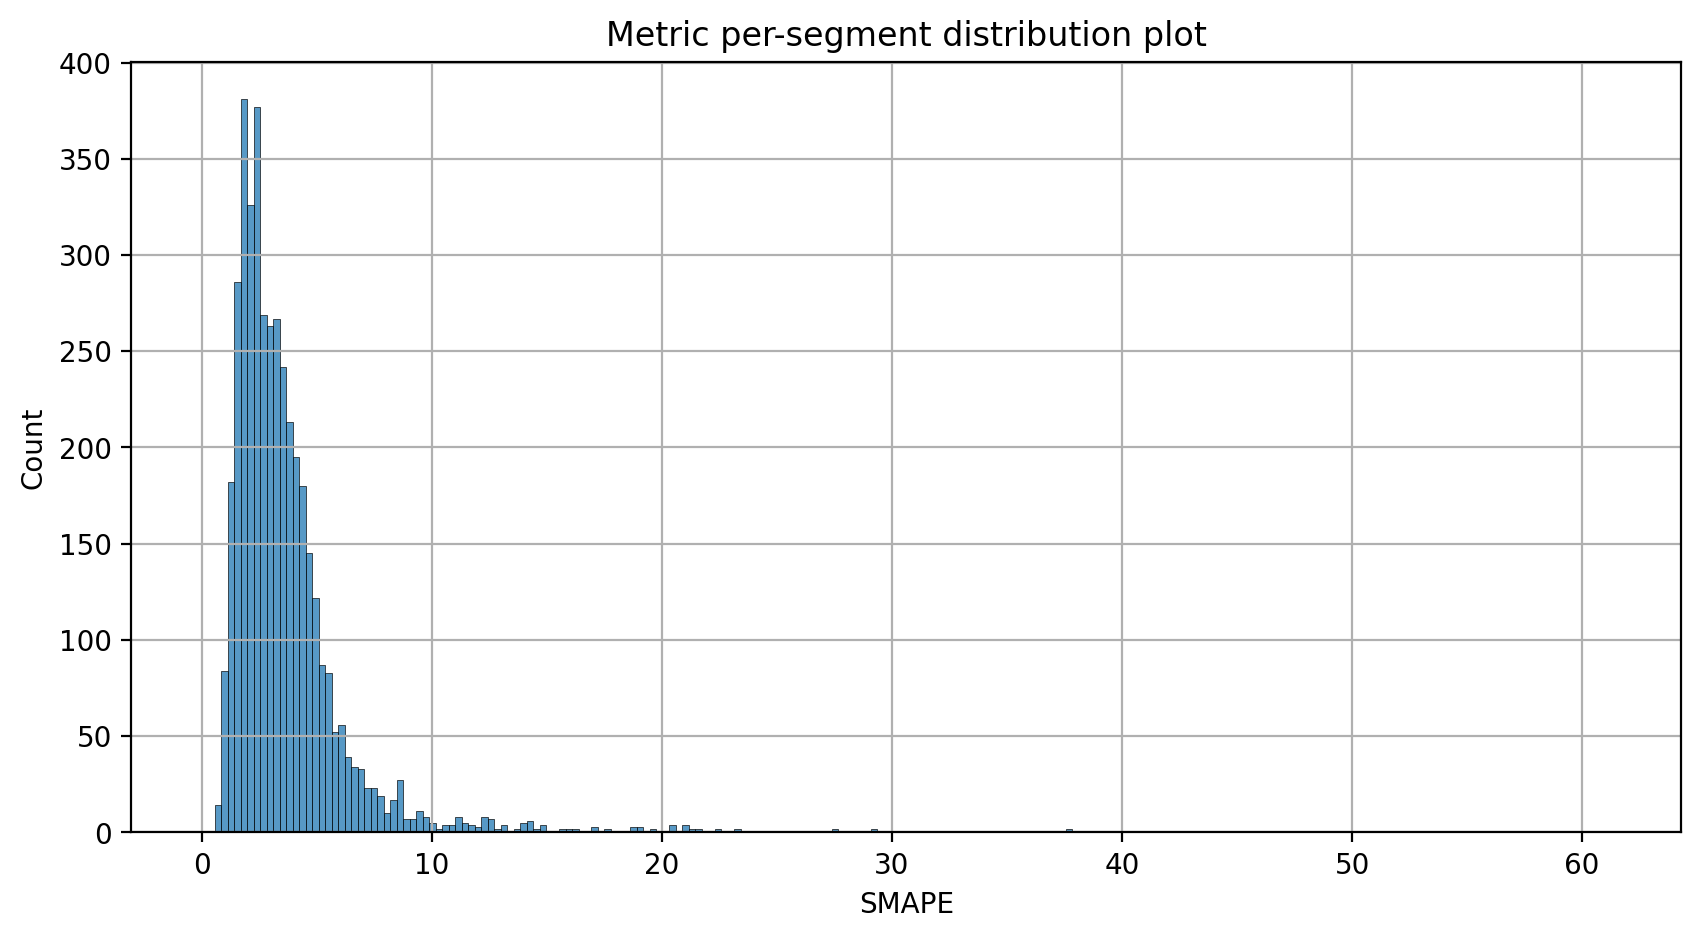

In [10]:
# выводим распределение метрики SMAPE, усредненной по результатам 
# перекрестной проверки для всех временных рядов
metric_per_segment_distribution_plot(
    metrics_df=metrics, 
    metric_name='SMAPE', 
    per_fold_aggregation_mode='mean')

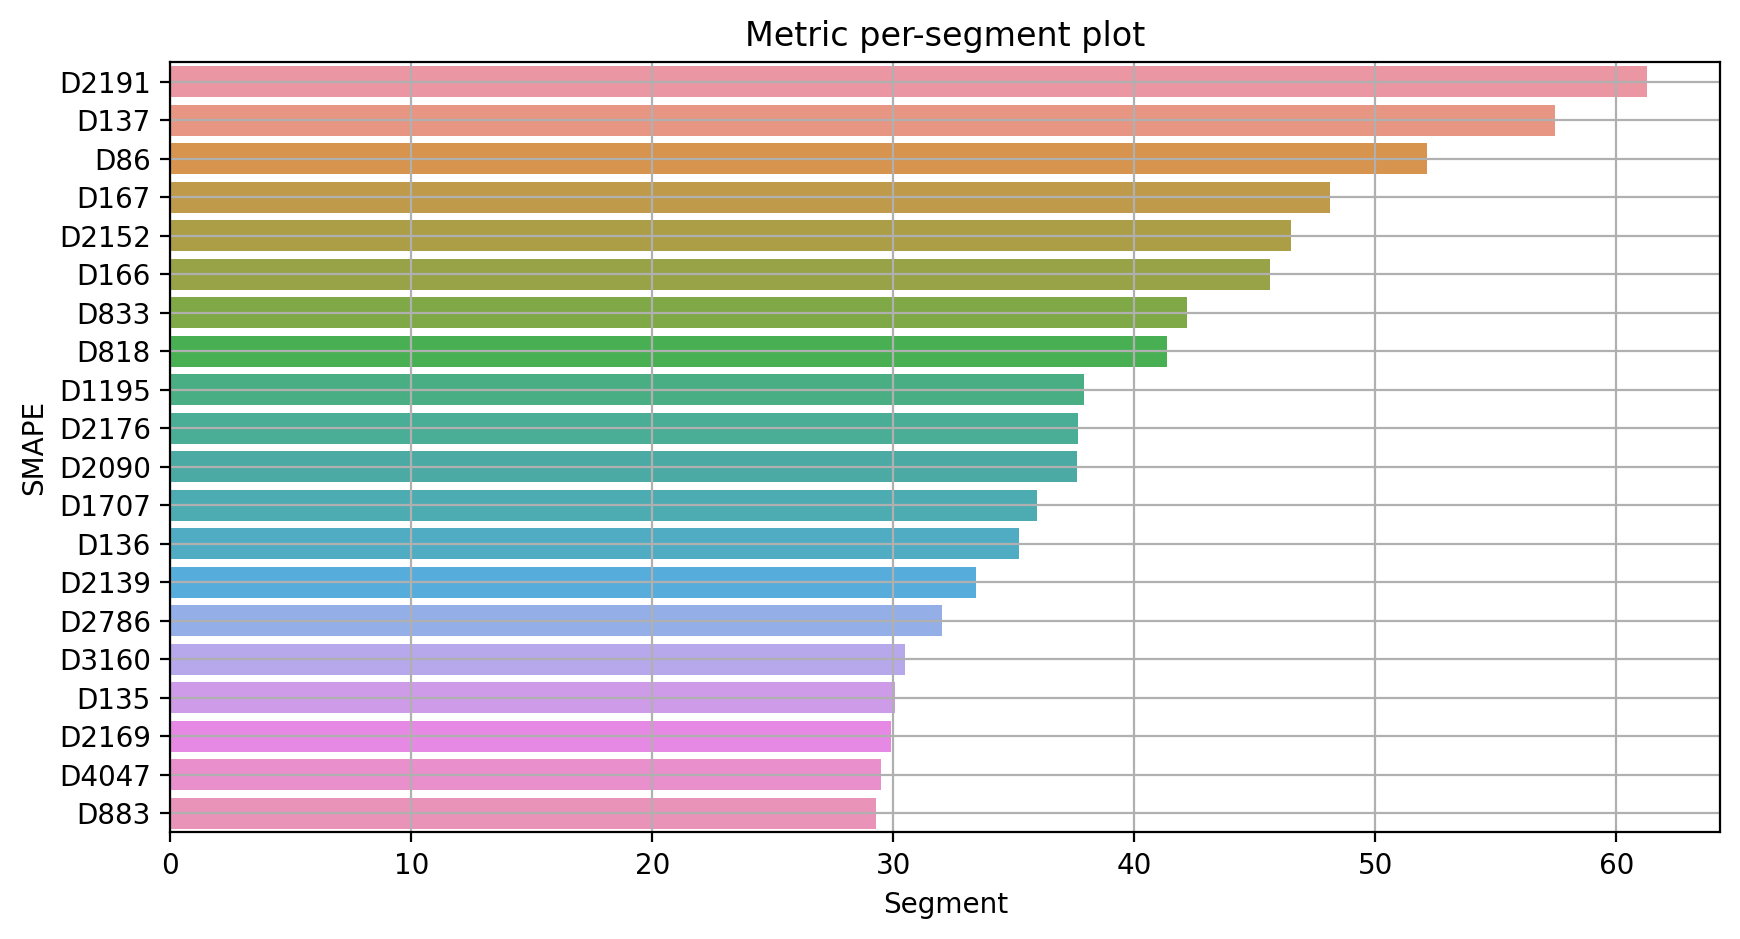

In [11]:
# выводим топ-20 временных рядов с наихудшими
# значениями метрики SMAPE
plot_metric_per_segment(metrics_df=metrics, 
                        metric_name='SMAPE', 
                        top_k=20)

In [12]:
# считаем количество временных рядов со значениями
# метрики SMAPE больше или равной 20
agg_metrics = metrics.groupby('segment').mean().reset_index()
bad_segment_metrics = agg_metrics[agg_metrics['SMAPE'] >= 20]
print(f'Кол-во плохих сегментов: {len(bad_segment_metrics)}')

Кол-во плохих сегментов: 42


### Загрузка предварительно обученного анализатора  <a class="anchor" id="section_2"></a>

In [13]:
# импортируем класс PredictabilityAnalyzer 
# - анализатор прогнозируемости
from etna.experimental.classification import PredictabilityAnalyzer

Давайте посмотрим на список доступных методов извлечения признаков.

In [14]:
# выводим методы извлечения признаков предобученного 
# анализатора предсказуемости
PredictabilityAnalyzer.get_available_models()

['weasel', 'tsfresh', 'tsfresh_min']

Предварительно обученный анализатор можно загрузить по названию способа извлечения признаков и частоте набора данных.

In [15]:
# загружаем предобученный анализатор прогнозируемости, 
# указав способ извлечения признаков WEASEL, дневную
# частоту и путь сохранения файла модели
PredictabilityAnalyzer.download_model(model_name='weasel', 
                                      dataset_freq='D', 
                                      path='weasel_analyzer.pickle')

In [16]:
# создаем модель 
weasel_analyzer = PredictabilityAnalyzer.load('weasel_analyzer.pickle')

### Анализ прогнозируемости сегментов   <a class="anchor" id="section_3"></a>

In [17]:
# создаем функцию подсчета количества 
# непрогнозируемых временных рядов
def metrics_for_bad_segments(predictability):
    bad_segments = [segment for segment in predictability
                    if predictability[segment] == 1]
    metrics_for_bad_segments = agg_metrics[
        agg_metrics['segment'].isin(bad_segments)].sort_values(
        'SMAPE', ascending=False
    )
    print(f'Number of bad segments: {len(metrics_for_bad_segments)}')
    return metrics_for_bad_segments

Теперь мы можем проанализировать набор данных на прогнозируемость, это можно сделать двумя способами.
1. Короткий путь: используя метод `.analyze_predictability()`.

In [18]:
%%time

# считаем количество непрогнозируемых временных рядов
predictability = weasel_analyzer.analyze_predictability(ts)

CPU times: user 10.8 s, sys: 381 ms, total: 11.2 s
Wall time: 11.2 s


In [19]:
# выводим количество непрогнозируемых временных рядов
metrics = metrics_for_bad_segments(predictability)

Number of bad segments: 133


2. Длинный путь: используя метод `.predict_proba()`. Он более гибкий, так как вы можете выбрать порог прогнозируемости.

In [20]:
%%time

# рассчитываем прогнозируемость каждого временного ряда
series = weasel_analyzer.get_series_from_dataset(ts)
predictability_score = weasel_analyzer.predict_proba(series)

CPU times: user 10.1 s, sys: 288 ms, total: 10.4 s
Wall time: 10.4 s


In [21]:
# считаем количество непрогнозируемых 
# временных рядов по заданному порогу
threshold = 0.4
predictability = {segment: int(predictability_score[i] > threshold) 
                  for i, segment in enumerate(sorted(ts.segments))}

In [22]:
# выводим количество непрогнозируемых временных рядов
metrics = metrics_for_bad_segments(predictability)

Number of bad segments: 406


Давайте посмотрим на сегменты с плохими значениями метрик.

In [23]:
# печатаем метрики для топ-10 самых плохо 
# прогнозируемых временных рядов
metrics.head(10)

,segment,SMAPE,fold_number
412,D137,57.452473,1.0
4072,D86,52.144064,1.0
734,D166,45.620776,1.0
3387,D4047,29.501460,1.0
1310,D2178,29.205434,1.0
4061,D85,22.579621,1.0
1205,D2083,22.547771,1.0
3333,D4,20.994039,1.0
357,D132,15.903925,1.0
2778,D35,14.327464,1.0


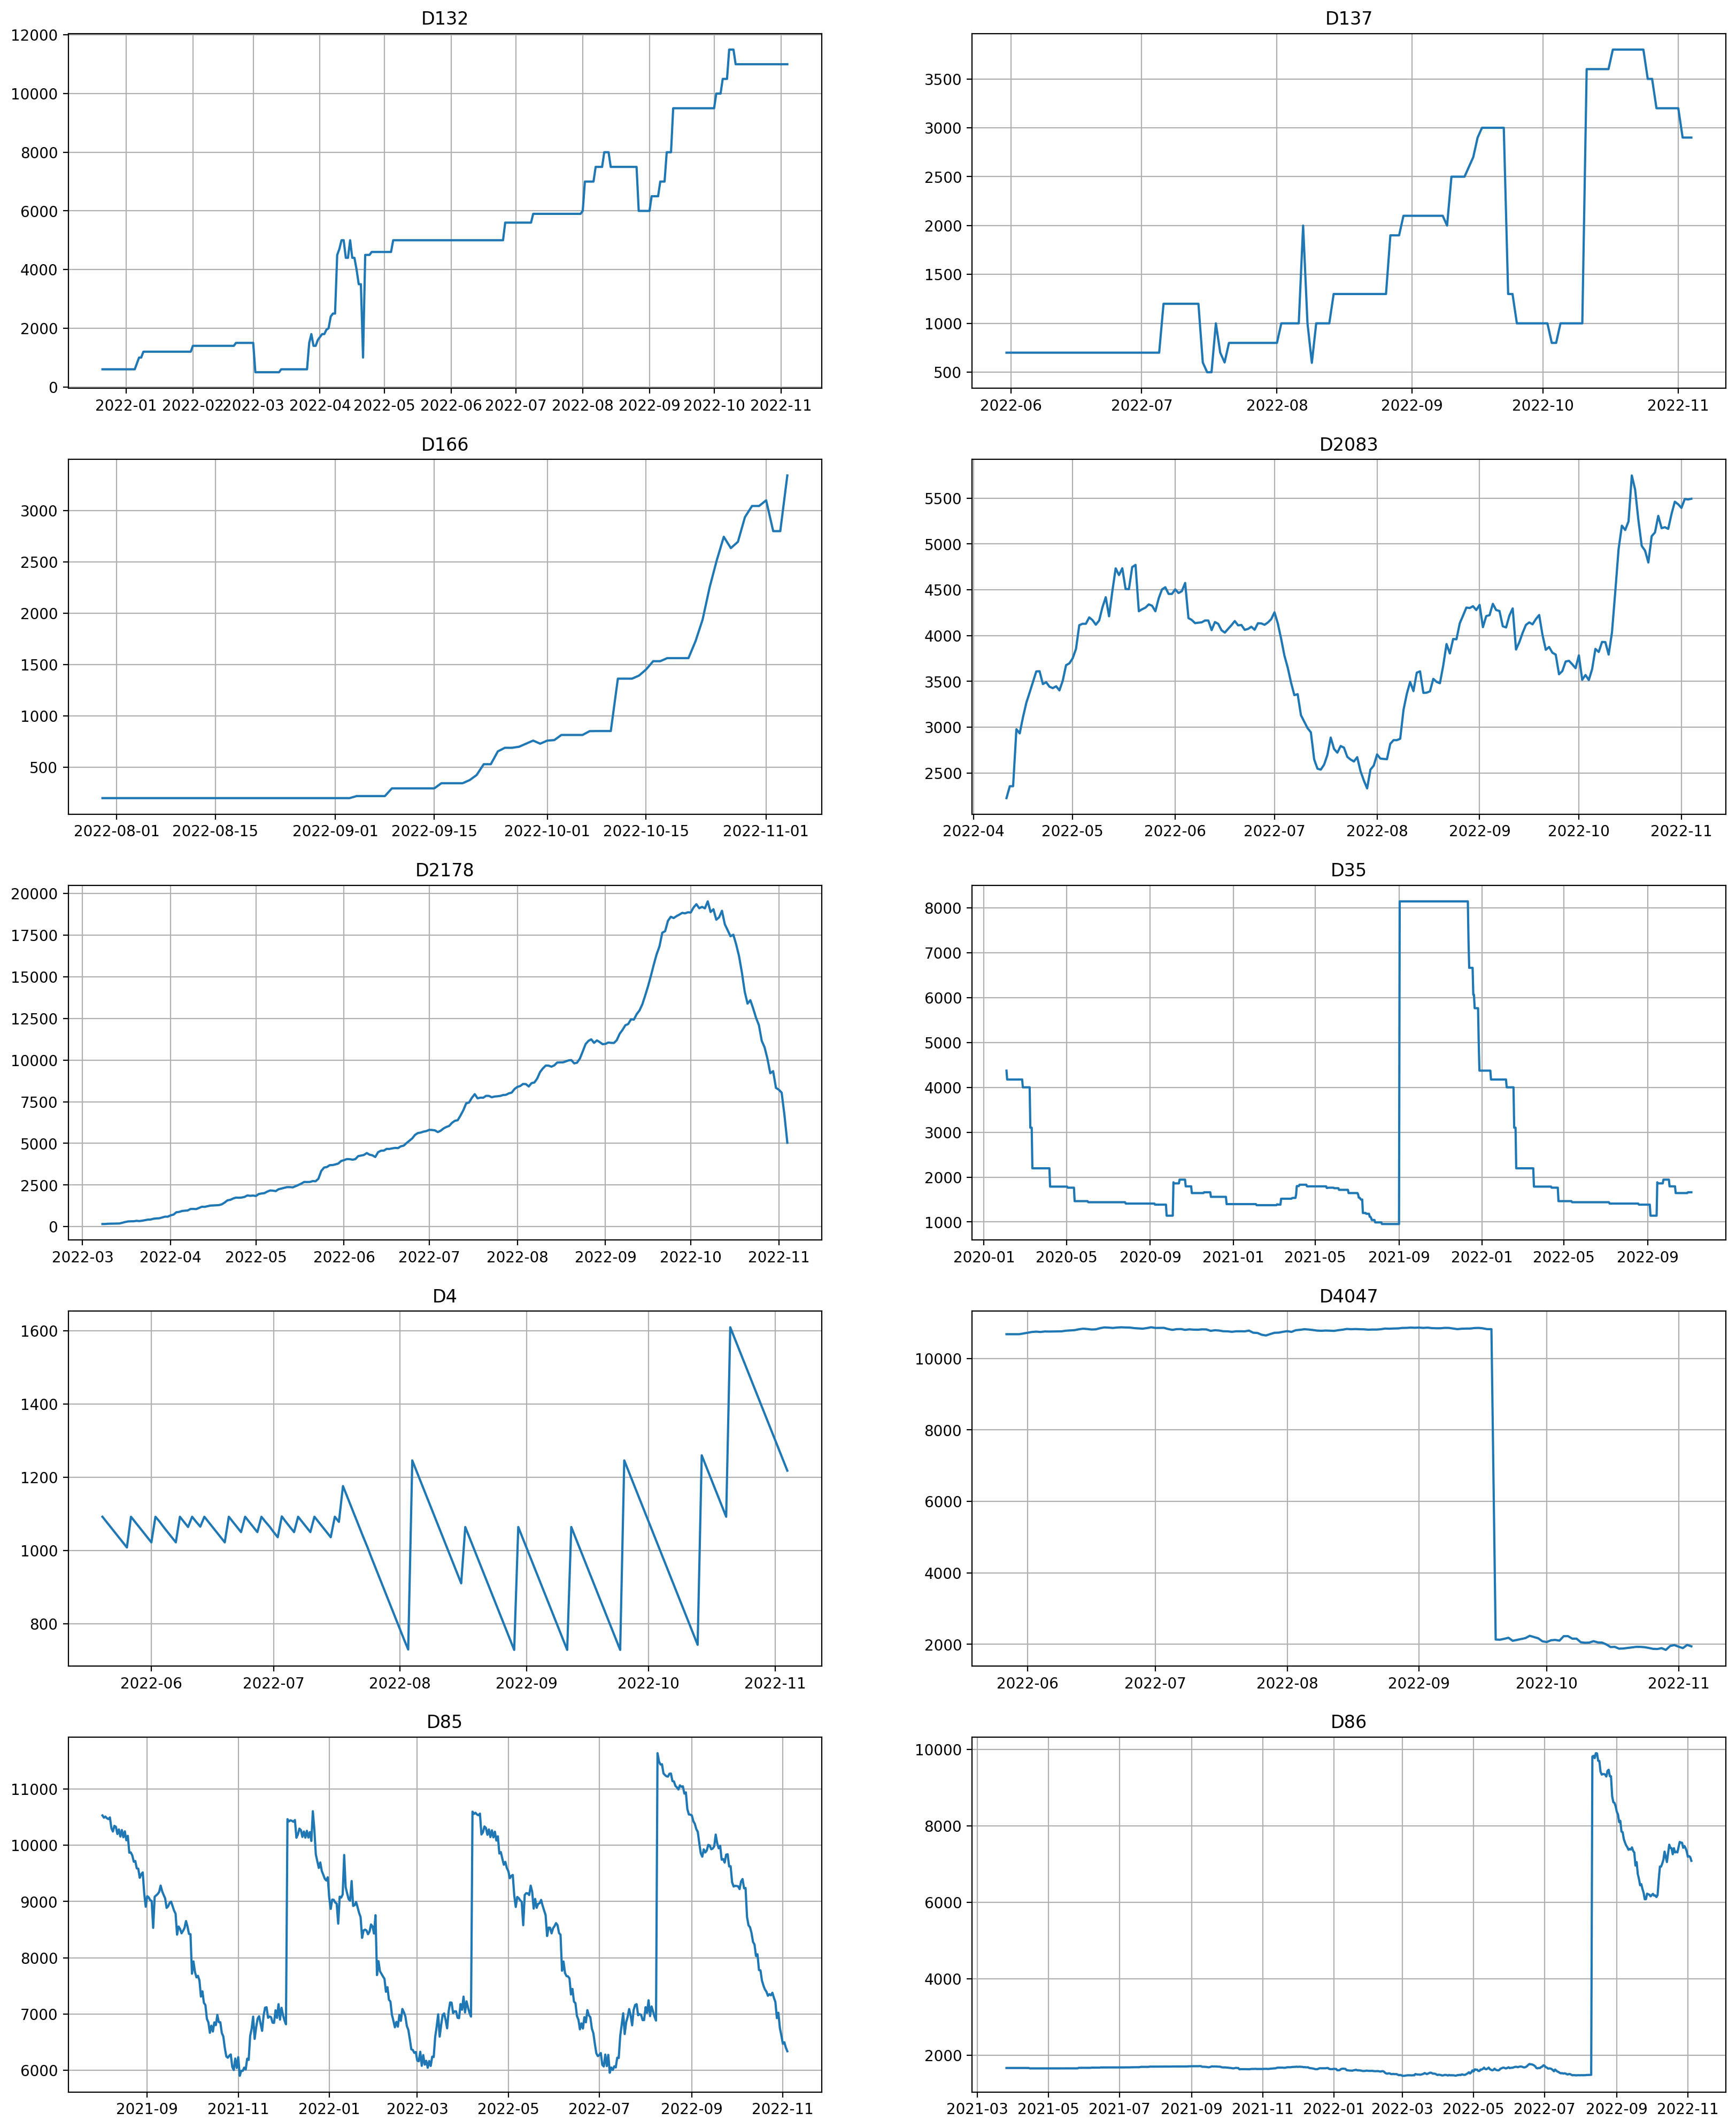

In [24]:
# визуализируем топ-10 самых плохо 
# прогнозируемых временных рядов
ts.plot(segments=metrics.head(10)['segment'])

Анализ набора данных и формирование набора возможных плохих сегментов для анализатора на основе WEASEL занял всего около 15 секунд, что гораздо быстрее, чем при использовании любого базового конвейера.

Однако в результатах могут быть ложно-положительные срабатывания.

In [25]:
# печатаем метрики для топ-10 самых хорошо 
# прогнозируемых временных рядов
metrics.tail(10)

,segment,SMAPE,fold_number
1234,D2109,1.387898,1.0
2972,D3674,1.384460,1.0
3706,D53,1.294982,1.0
3534,D418,1.281990,1.0
2167,D295,1.258861,1.0
2457,D321,1.177998,1.0
2446,D320,1.123942,1.0
3242,D3917,1.010831,1.0
346,D131,0.487805,1.0
1348,D2211,0.000000,1.0


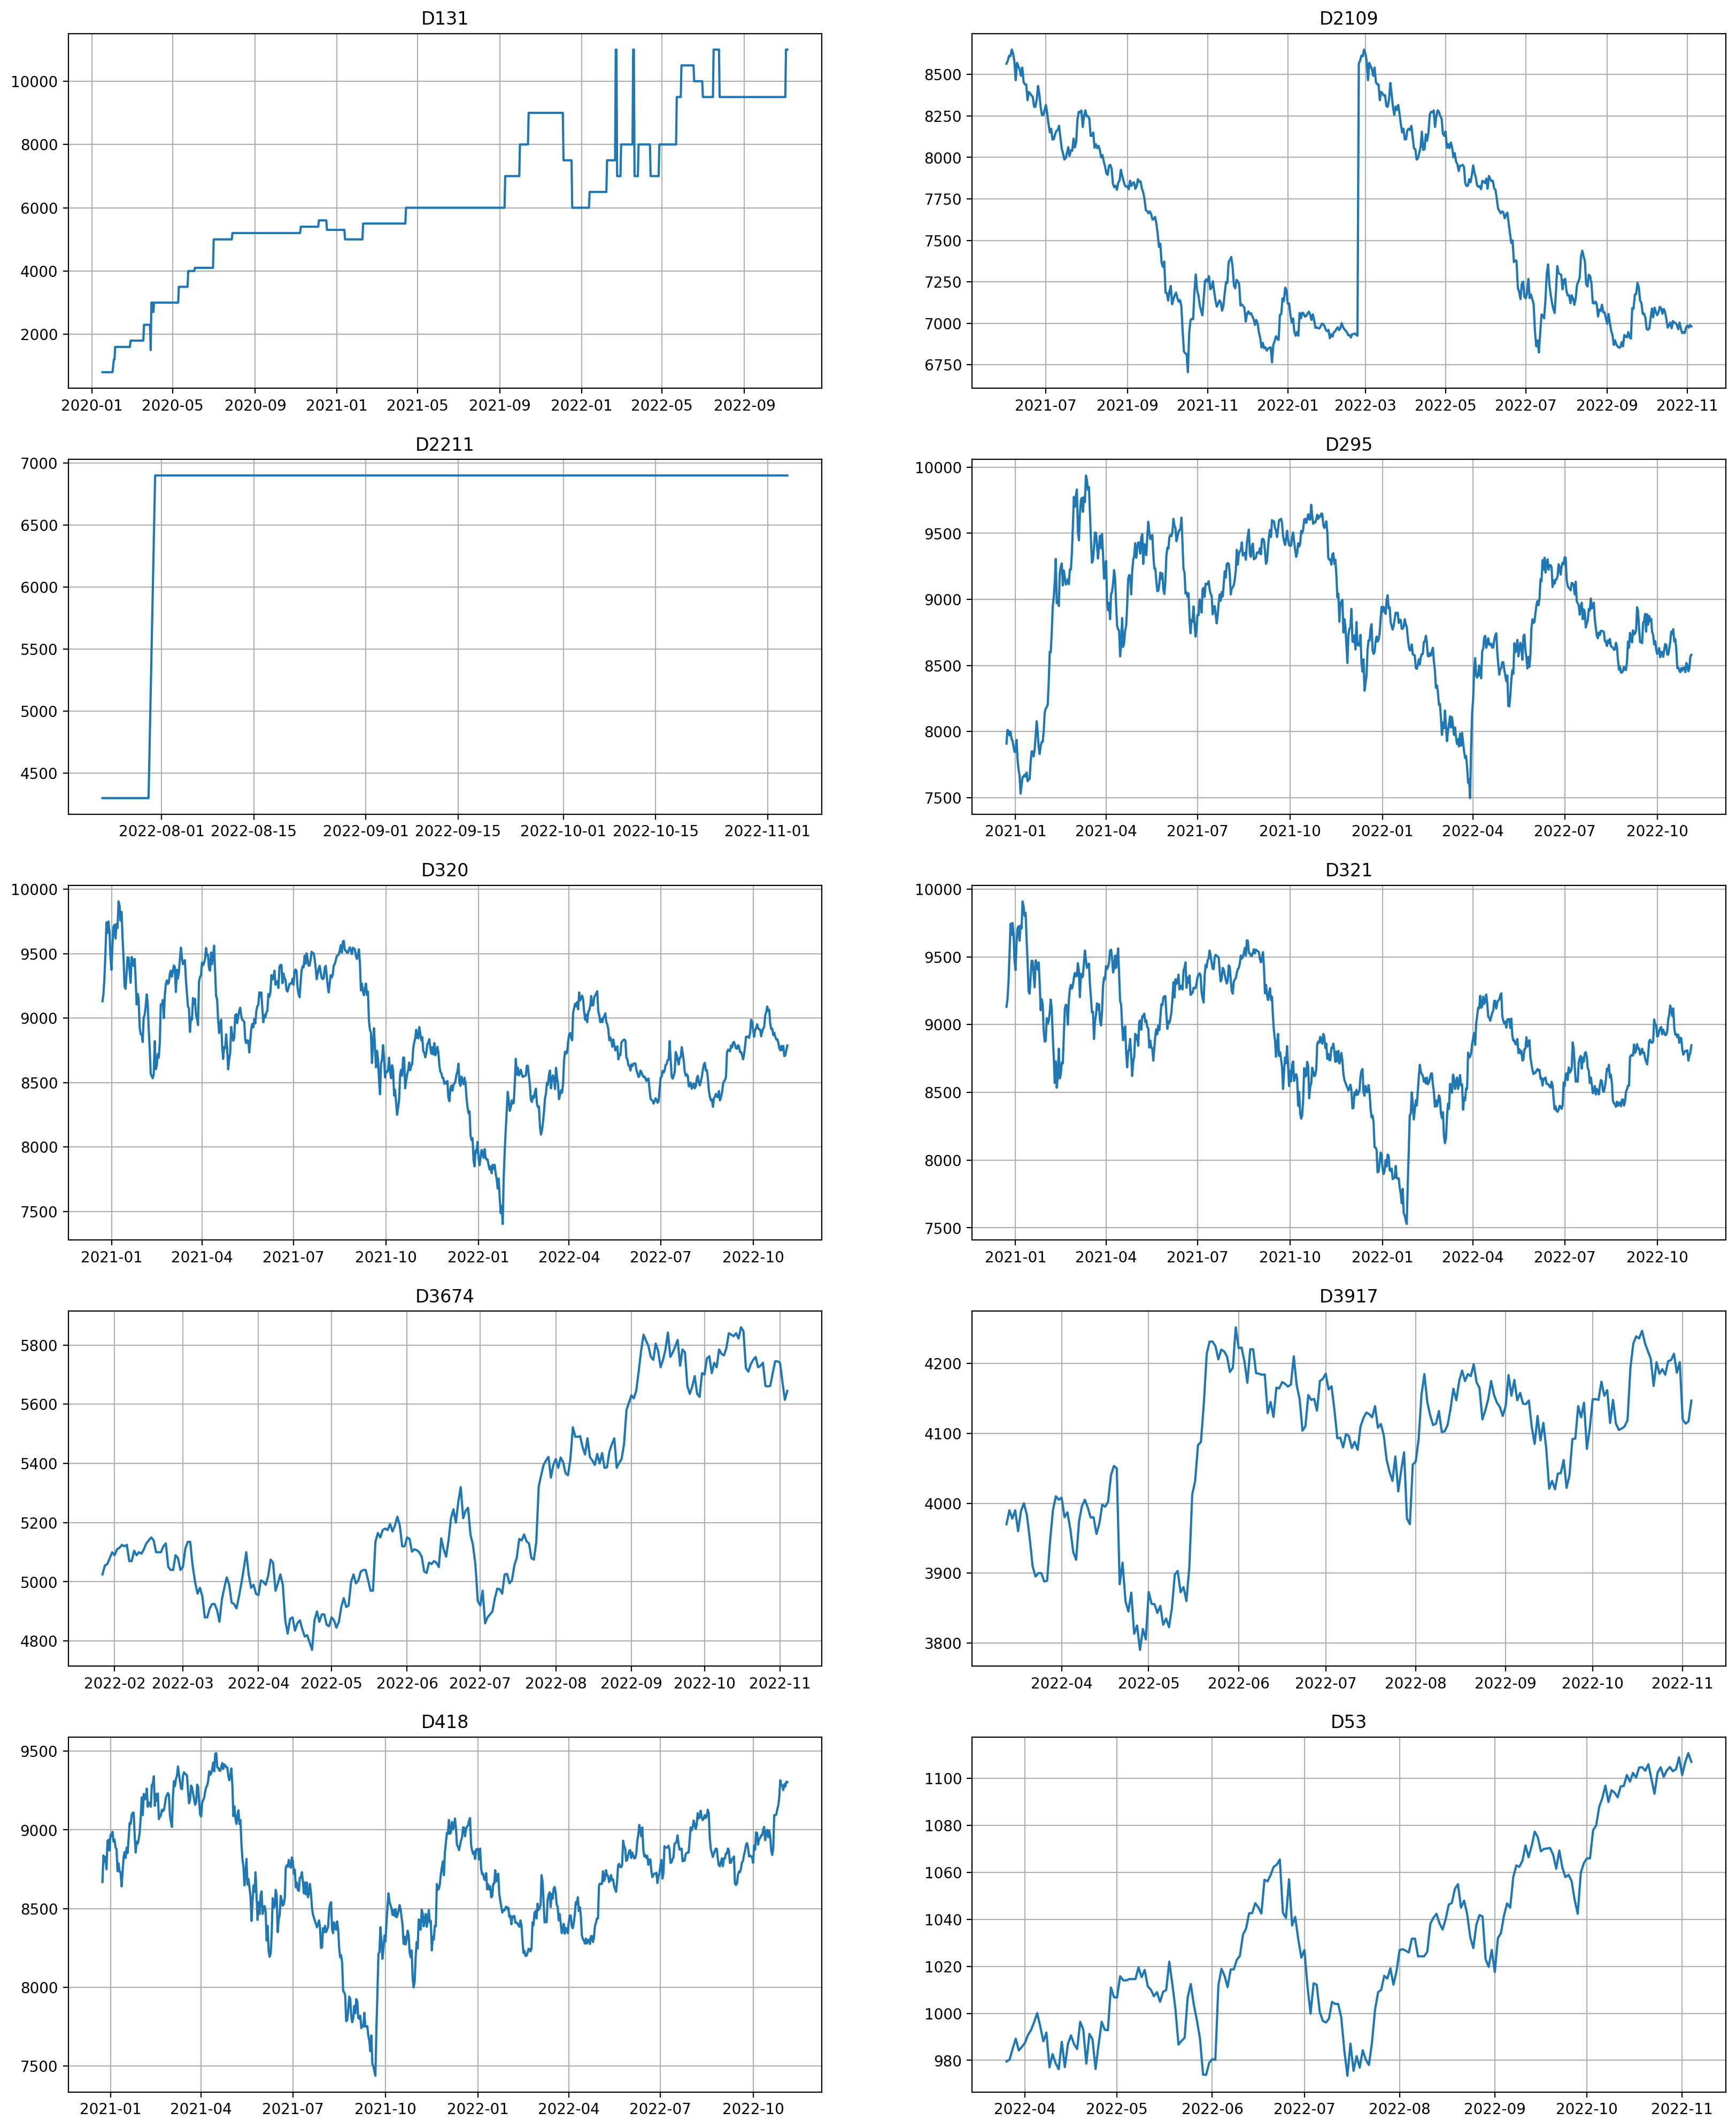

In [26]:
# визуализируем топ-10 самых хорошо 
# прогнозируемых временных рядов
ts.plot(segments=metrics.tail(10)['segment'])